In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
class Padim(nn.Module):
    def __init__(self):
        super(Padim, self).__init__()
        # Pretrained ResNet18 backbone (remove FC + pooling layers)
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-4])

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        feat = self.backbone(x)  # [B, C, H/32, W/32]
        B, C, H, W = feat.shape
        print(feat.shape)
        # flatten spatial dims -> patches
        patch_embeds = feat.permute(0, 2, 3, 1).reshape(B, H * W, C)  # [B, N, C] where N=H*W

        return patch_embeds, H, W


In [ ]:
def mahalanobis_global(patch_embeds, eps=1e-6):
    """
    patch_embeds : [B, N, C]
    returns:
    scores : [B, N]
    """

    B, N, C = patch_embeds.shape

    # Global mean and cov across patches
    mean = patch_embeds.view(-1, C).mean(dim=0)  # [C]
    delta = patch_embeds - mean.view(1, 1, C)  # [B, N, C]

    cov = torch.einsum('bnc,bnd->cd', delta, delta) / (B * N - 1 + eps)  # [C, C]
    cov += eps * torch.eye(C, device=patch_embeds.device)

    cov_inv = torch.linalg.inv(cov)  # [C, C]

    # Mahalanobis distance
    m_dist = torch.einsum('bnc,cd,bnd->bn', delta, cov_inv, delta)  # [B, N]

    return m_dist.sqrt()


In [ ]:
def compute_anomaly_map(scores, feat_H, feat_W):
    """
    scores : [B, N] torch.Tensor
    returns:
    anomaly_map : [B, 1, feat_H, feat_W] torch.Tensor
    """
    if isinstance(scores, tuple):
        scores = torch.stack(scores, dim=0)  # convert list of tensors to [B, N]

    B, N = scores.shape
    assert N == feat_H * feat_W, f"Mismatch: N={N} vs feat_H*feat_W={feat_H*feat_W}"

    anomaly_map = scores.view(B, 1, feat_H, feat_W)  # reshape
    anomaly_map = F.interpolate(anomaly_map, scale_factor=32, mode='bilinear', align_corners=False)

    return anomaly_map


In [ ]:
x = cv2.imread('/content/Screenshot 2025-04-09 002603.png')
# resize to 512 512
x = cv2.resize(x, (512, 512))
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

x = x / 255.0  # [0,255] -> [0,1]
x = torch.from_numpy(x).permute(2, 0, 1).unsqueeze(0).float()

model = Padim()

embeds, feat_H, feat_W = model(x)

print(embeds)

scores = mahalanobis_global(embeds)

torch.Size([1, 128, 64, 64])
tensor([[[0.5627, 0.2230, 0.8861,  ..., 0.0000, 1.5391, 0.6264],
         [0.0846, 0.0000, 0.2136,  ..., 0.0000, 0.3398, 1.9448],
         [0.5382, 0.0000, 0.0000,  ..., 0.0000, 0.5534, 1.9185],
         ...,
         [0.0000, 0.1641, 0.0000,  ..., 0.0000, 0.0729, 0.0000],
         [0.0000, 0.0906, 0.2232,  ..., 0.0000, 0.2764, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2865, 0.0000]]])


In [ ]:
x.shape, embeds.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 4096, 128]))

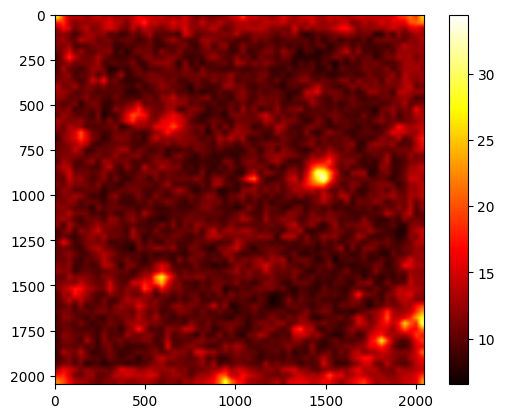

In [ ]:
# print(scores, feat_H, feat_W)
# for item in scores:
#     print(item.shape)
anomaly_map = compute_anomaly_map(scores, feat_H, feat_W)

plt.imshow(anomaly_map[0, 0].detach().cpu().numpy(), cmap='hot')
plt.colorbar()
plt.show()